In [1]:
import sys; sys.path.append('../3rdparty/ElasticRods/python')
import elastic_rods, scipy, numpy as np, time, matplotlib, matplotlib.pyplot as plt

import finite_diff
from linkage_vis import LinkageViewer as Viewer
from helpers import define_periodic_rod, define_periodic_circle, color_rods

%load_ext autoreload
%autoreload 2

 - [Test a single `PeriodicRod`](#sec:periodic_rod)
 - [Test `PeriodicRod`s with contacts](#sec:periodic_rods_with_contacts)

----

<a id='sec:periodic_rod'></a>
# Test a single `PeriodicRod`

In [2]:
# Define PeriodicRod
r = 1
rod_radius = 0.1
z_noise = 1e-2*r
totOpenAngle = 1e-1
material = elastic_rods.RodMaterial('ellipse', 2000, 0.3, [rod_radius, rod_radius])
pr = define_periodic_circle(npts=6, material=material, r=r, z_noise=z_noise)
pr.totalOpeningAngle = totOpenAngle
npts = pr.numVertices()

In [3]:
view = Viewer(pr, width=640, height=480)
view.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

### Test gradient and Hessian

In [4]:
seed = 0
np.random.seed(seed)
direction = np.random.uniform(-1, 1, pr.numDoF())

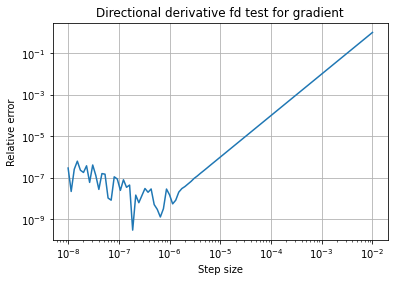

In [5]:
finite_diff.gradient_convergence_plot(pr, direction=direction)

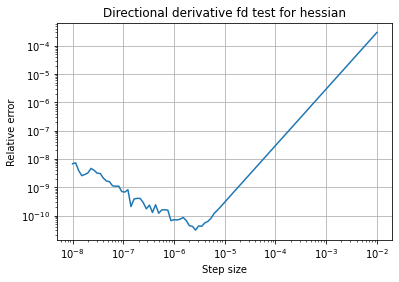

In [6]:
finite_diff.hessian_convergence_plot(pr, direction=direction)

<a id='sec:periodic_rods_with_contacts'></a>
# Test `PeriodicRod`s with contacts

In [7]:
import elastic_knots

In [8]:
# Define rods
r = 1
rod_radius = 0.1
z_noise = 1e-2*r
totOpenAngle = 1e-1
material = elastic_rods.RodMaterial('ellipse', 2000, 0.3, [rod_radius, rod_radius])
pr0 = define_periodic_circle(npts=6, material=material, r=r, z_noise=z_noise)
pr1 = define_periodic_circle(npts=10, material=material, r=r, translation=np.array([0.8*r, 0, 2*rod_radius]), z_noise=z_noise)
pr0.totalOpeningAngle = totOpenAngle
pr1.totalOpeningAngle = totOpenAngle
rod_list = elastic_knots.PeriodicRodList([pr0, pr1])
npts = rod_list.numVertices()

In [9]:
# Define problem
problemOptions = elastic_knots.ContactProblemOptions()
problemOptions.dHat = 2.5*rod_radius  # use a slightly larger collision distance to detect a few more contacts in this test

problem = elastic_knots.ContactProblem(rod_list, problemOptions)

softConstraints = [
    elastic_knots.FlatnessConstraint(stiffness=1, n=[1, 2, 3], center=[0.1, 0.3, 0.5], upper_d=0.2, lower_d=0.1),
    elastic_knots.SphericalShellConstraint(stiffness=1, center=[0.1, 0.3, 0.5], upper_d=0.002, lower_d=0.001),
    elastic_knots.VolumeConstraint(stiffness=1, aspectRatio=[1, 4, 7]),
]
problem.addSoftConstraints(softConstraints)

problem.updateConstraintSet()

In [10]:
viewRods = Viewer(rod_list, width=640, height=480)
viewRods.setCameraParams(
    ((-0.056120199599739524, -3.688911554799623, 3.374726961409275),
     (-0.011812746465884814, 0.6750386414570663, 0.7376878008756365),
     (0.0, 0.0, 0.0))
)
viewRods.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

In [11]:
color_rods(viewRods, rod_list)   # dark blue and dark red represent the first and last edges of each rod, respectively

### Test gradient and Hessian

In [12]:
seed = 0
np.random.seed(seed)
direction = np.random.uniform(-1, 1, problem.numVars())

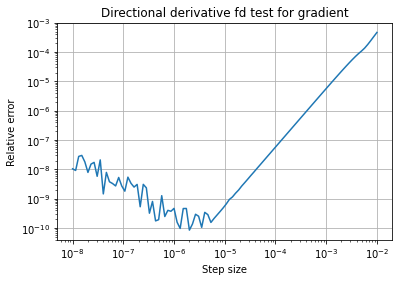

In [13]:
finite_diff.gradient_convergence_plot(problem, direction=direction)

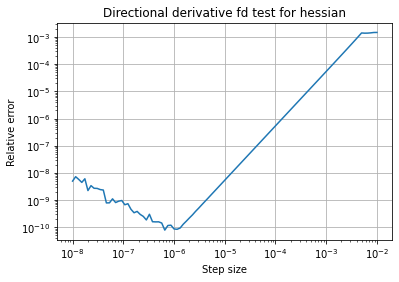

In [14]:
finite_diff.hessian_convergence_plot(problem, direction=direction)

### Visualize Hessian sparsity pattern

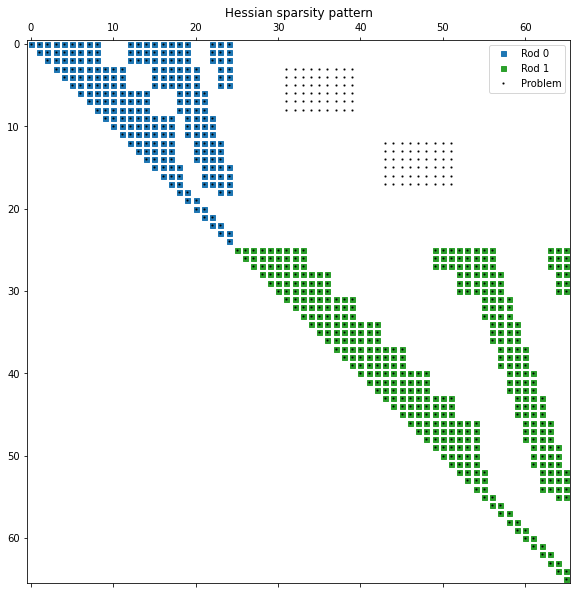

In [18]:
hessian_pr0 = pr0.hessianSparsityPattern(1.0).toSciPy()
hessian_pr1 = pr1.hessianSparsityPattern(1.0).toSciPy()
hessian_prob = problem.hessianSparsityPattern().toSciPy()  # problem's hessian, includes contacts
hessian_prob.data[:] = 1  # fill with ones

# South-East shift rod 1
from scipy.sparse import csr_matrix
nv = problem.numVars()
mat = np.zeros((nv, nv))
upperLeft = rod_list.firstGlobalDofIndexInRod(1)
lowerRight = upperLeft + rod_list.numDoFInRod(1)
mat[upperLeft:lowerRight, upperLeft:lowerRight] = hessian_pr1.todense()
hessian_pr1 = csr_matrix(mat)

fig, ax = plt.subplots(figsize=(10, 10))
ax.spy(hessian_pr0,    **{'c': 'C0',  'ms': 5, 'label': 'Rod 0'})
ax.spy(hessian_pr1,    **{'c': 'C2',  'ms': 5, 'label': 'Rod 1'})
ax.spy(hessian_prob, **{'c': 'k',   'ms': 1, 'label': 'Problem'})
ax.legend()
ax.set_title('Hessian sparsity pattern')

plt.show()